# Matching DC population data with users of the Meetup app
### Junye Li, Ben Brown, Juntao Wang & Ward Anderson
### CS 181
### Dr. Kretchmar
### 12/17/18

In [2]:
import meetup.api
import json 
import requests 
import time 
import codecs
import sys
import io
import re
import pandas as pd
import sqlalchemy as sa
import string

## Introduction

The DC Metropolitan has three parts; Northern Virginia, the District of Columbia, and the DC border of  Maryland. The DC metro population is 6,131,977. Of that population, 3,002,348 live in Virginia, 2,448,459 live in Maryland, and 681,170 live in DC. However, many commute into DC for their professions. This supports why the DC area has some of the worst traffic nationwide (https://wtop.com/dc-transit/2017/02/bad-dc-traffic-new-report-ranks-car-clogged-cities/ ).

Bearing these factors in mind, our group wanted to test if the same would be true for a DC-based Meetup group. Meetup is an application designed for people of similar interests to congregate together in any location. We wanted to investigate the extent to which the geographic distribution of Meetup users reflected the population distribution of DC inhabitants at large. Initially, we hypothesized that any sample of DC residents via Meetup would be representative of overall population patterns.

## Methods
We retrieved data from two sources; Wikipedia and Meetup.com. On Wikipedia, we web scraped 2016 Census population data pertaining to the Washington DC Metropolitan area from https://en.wikipedia.org/wiki/Washington_metropolitan_area. Similarly, we obtained data from members (25,000+) of the “DC-Tech-Meetup” group in the Meetup application using the python Meetup-API module (https://www.meetup.com/meetup_api/ ). Meetup’s API contains each member’s geographical location in terms of longitude and latitude from their initial IP address. We chose to get data from DC-Tech-Meetup group due to its large size and central location in the DC Metropolitan area. 
Below are the functions we wrote to extract and analyze data.

In [6]:
def getCreds(filename,subset,defaults={}):
    '''
    This function helps us connect to a database on hadoop2.  The
    userid password information is stored in a local file encoded
    in json format.  
    Parameters:
    filename is where json encoded userid/password information stored
    subset: dictionary key in json file
    defaults: alternative way to connect to database
    Returns: subdictionary based on subset parameter.
    '''
    try:
        with open(filename,'r') as file:
            D = json.load(file)
            file.close()
            if D[subset]:
                return D[subset]
            else:
                return defaults
    except:
        return defaults

def db_setup(userid,password):
    '''
    This function connects us to a database using our login credentials. 
    Paramters:
    userid - string with our userid
    password - string with our password
    database - string with database name
    Returns:
    SQL engine and SQL connection objects
    '''
    template = 'mysql+mysqlconnector://{}:{}@hadoop2.mathsci.denison.edu/'
    cstring = template.format(userid,password)
    engine = sa.create_engine(cstring)
    connection = engine.connect()
    
    return engine, connection

def db_setup2(userid,password,database):
    '''
    This function connects us to a database using our login credentials. 
    Paramters:
    userid - string with our userid
    password - string with our password
    database - string with database name
    Returns:
    SQL engine and SQL connection objects
    '''
    template = 'mysql+mysqlconnector://{}:{}@hadoop2.mathsci.denison.edu/{}'
    cstring = template.format(userid,password,database)
    engine = sa.create_engine(cstring)
    connection = engine.connect()
    
    return engine, connection

def scrapeData(protocol, host, resource):
    '''
    This function takes elements of a URL and returns the raw text from
    the webpage.
    Parameters: protocol, host, resource
    Returns: response text
    '''
    template = "{}://{}{}"
    url = template.format(protocol, host, resource)
    resp = requests.get(url)
    if resp.status_code == 200:
        return resp.text
    print("Error")

def extractSectionBetween(txt, start, end):
    '''
    Slices text by substring boundaries rather than index boundaries.
    Parameters: text to slice, start string, end string
    Returns: trimmed string
    '''
    startInd = txt.find(start)
    endInd = txt.find(end)
    return txt[startInd:endInd]

def recreateTable(txt):
    '''
    Takes text containing a table in raw HTML format and
    places desired data in a pandas data frame.
    Parameters: html text
    Returns: pandas data frame
    '''
    pat = re.compile(r"<td><a .*?>(?P<county>.*?)<\/a>\n<\/td>\n<td .*?>(?P<pop>.*?)\n<\/td>")
    countyid = []
    i = 1
    county = []
    state = []
    pop = []
    for m in pat.finditer(txt):
        county.append(m["county"].split(",")[0].strip())
        state.append(m["county"].split(",")[1].strip())
        pop.append(int(m["pop"].replace(",", "")))
        countyid.append(i)
        i += 1
    return pd.DataFrame({"CountyID":countyid, "County":county, "State":state, "Population":pop})

def makeDataFrame(name, uid, state, city, lon, lat):
    '''
    This function is used in the api access function to turn the collected data into
    a neat data frame.
    Parameters: lists for name, uid, state, city, lon, and lat fields
    Returns: data frame
    '''
    for i in range(len(name)):
        try:
            state[i]=StateMap[state[i]]
        except KeyError:
            state[i]=StateMap['Skyrim']
        for j in name[i]: 
            if (j not in string.printable) or (j in string.punctuation):
                name[i] = 'badName'
                break
    df = pd.DataFrame({"name":name, "uid":uid, "state":state, "city":city, "lon":lon, "lat":lat})
    return df

def superFetch(groupname, key):
    '''
    This function accesses the api for the meetup app and gathers member data
    about the group whose name is provided.
    Parameters: string groupname, string key
    Returns: data frame of results
    Side effects: 
    '''
    print("Start fetching...")
    client = meetup.api.Client(key)
    print('request status:',end=' ')
    group = client.GetGroup({'urlname':groupname})
    gid = group.id
    total = group.members
    want = 'id,name,state,city,lon,lat'
    limit = 200
    request = total//limit+1
    offsetValue = 0
    name = []
    uid = []
    state = []
    city = []
    lon = []
    lat = []
    while (offsetValue!=request):
        print('progress: ',offsetValue+1,'/',request, sep='', end=' ')
        print('request status:',end=' ')
        try:
            members = client.GetMembers(group_id=gid, only=want,page=limit,offset=offsetValue)
            offsetValue+=1
            rList= members.results
            for j in rList:
                if len(j.keys())==6:
                    name.append(j['name'])
                    uid.append(j['id'])
                    state.append(j['state'])
                    city.append(j['city'])
                    lon.append(j['lon'])
                    lat.append(j['lat'])
                else:
                    uid.append(j['id'])
                    lon.append(j['lon'])
                    lat.append(j['lat'])
                    try:
                        name.append(j['name'])
                    except KeyError:
                        name.append('badName')
                    try:
                        city.append(j['city'])
                    except KeyError:
                        city.append('Whiterun')
                    try:
                        state.append(j['state'])
                    except KeyError:
                        state.append('Skyrim')
        except json.decoder.JSONDecodeError:
            print("JSONDecodeError, retrying")
    print("fetching complete")
    df = makeDataFrame(name, uid, state, city, lon, lat)
    return df

def createDB(db_name):
    '''
    This function primes and exectues commands to create a database (w/ tables) of
    data collected via api and web scraping.
    Parameters: string database name
    Returns: None'''
    makeDB = "CREATE DATABASE "+db_name+";"
    makeCountyPopulations = "CREATE TABLE CountyPopulations(\
    CountyID INT NOT NULL,\
    CountyName VARCHAR(30),\
    StateID INT,\
    Population INT,\
    PRIMARY KEY(CountyID)\
    );"
    makeStates = "CREATE TABLE States(\
    StateID INT NOT NULL,\
    State VARCHAR(30),\
    PRIMARY KEY(StateID)\
    );"
    makeUsers = "CREATE TABLE Users(\
    MemberID INT NOT NULL,\
    Nickname VARCHAR(30),\
    StateID INT,\
    UserCity VARCHAR(30),\
    UserLongitude DECIMAL(5, 2),\
    UserLatitude DECIMAL(5, 2),\
    PRIMARY KEY(MemberID)\
    );"
    connection.execute("commit;")
    connection.execute(makeDB)
    connection.execute("USE "+db_name+";")
    connection.execute(makeCountyPopulations)
    connection.execute(makeStates)
    connection.execute(makeUsers)
    
def insertCounty(df):
    '''
    This function adds rows to the table recording county populations.
    Parameters: data frame of data
    Returns: none
    '''
    valuesTemplate = '({},{},{},{})'
    countyRowTemplate = "INSERT INTO CountyPopulations(CountyID, CountyName, StateID, Population)VALUES{};"
    valueRows = ""
    for i in range(len(df)):
        countyRow = valuesTemplate.format(df.iloc[i, 0], "'"+df.iloc[i, 1].replace("'", "")+"'", df.iloc[i, 2], df.iloc[i, 3])
        valueRows += "," + countyRow
    insertString = countyRowTemplate.format(valueRows[1:])
    connection.execute(insertString)
    
def insertUser(df):
    '''
    This function adds all of the users to the Users table in the database.
    Parameters: data frame of data
    Returns: none
    '''
    valuesTemplate = '({},{},{},{},{},{})'
    usersRowTemplate = "INSERT INTO Users(MemberID, Nickname, StateID, UserCity, UserLongitude, UserLatitude)VALUES{};"
    valueRows = ""
    for i in range(len(df)):
        userRow = valuesTemplate.format(df.iloc[i,1], "'"+df.iloc[i, 0]+"'", df.iloc[i, 2], "'"+df.iloc[i, 3]+"'", df.iloc[i, 4], df.iloc[i, 5])
        valueRows += "," + userRow
    insertString = usersRowTemplate.format(valueRows[1:])
    connection.execute(insertString)

def insertState(StateMap):
    '''
    This function adds the rows to the table of states.
    Parameters: dictionary encoding states
    Returns: none
    '''
    StateList = list(StateMap.keys())
    StateIDList = list(StateMap.values())
    valuesTemplate = '({},{})'
    stateRowTemplate = "INSERT INTO States(StateID, State)VALUES{};"
    valueRows = ""
    for i in range(len(StateList)):
        stateRow = valuesTemplate.format(StateIDList[i], "'"+StateList[i]+"'")
        valueRows += "," + stateRow
    insertString = stateRowTemplate.format(valueRows[1:])
    connection.execute(insertString)
    
def SQLtoPandas(sqlQuery):
    '''
    This function takes a sql query and executes it, returning the resultant data frame.
    Parameters: string sql query
    Returns: data frame result
    '''
    queryProxy = connection.execute(sqlQuery)
    pandasDf = pd.DataFrame(queryProxy.fetchall(), columns = queryProxy.keys())
    return pandasDf
    
StateMap = {'AL':1,'AK':2,'AZ':3,'AR':4,'CA':5,'CO':6,'CT':7,'DE':8,'FL':9,'GA':10,'HI':11,'ID':12,'IL':13,'IN':14,
            'IA':15,'KS':16,'KY':17,'LA':18,'ME':19,'MD':20,'MA':21,'MI':22,'MN':23,'MS':24,'MO':25,'MT':26,'NE':27,
            'NV':28,'NH':29,'NJ':30,'NM':31,'NY':32,'NC':33,'ND':34,'OH':35,'OK':36,'OR':37,'PA':38,'RI':39,'SC':40,
            'SD':41,'TN':42,'TX':43,'UT':44,'VT':45,'VA':46,'WA':47,'WV':48,'WI':49,'WY':50,'DC':51,'Skyrim':52}

The functions “extractSectionBetween”, “recreateTable”, and  “scrapeData” were used to web scrape the Wikipedia page and make the subsequent dataframe. The functions “superFetch” and “makeDataFrame” were created to get extract data from the Meetup-API. The codes below were function calls to fetch data and create database.

In [ ]:
# key = '1a60703a102a6252424875415c1b21'
# userTable = superFetch('DC-Tech-Meetup', key)
# txt = scrapeData("https", "en.wikipedia.org", "/wiki/Washington_metropolitan_area")
# txt = extractSectionBetween(txt, "92.3 years", "The Washington, D.C. area has the largest science")
# popTable = recreateTable(txt)
# popTable["State"] = popTable["State"].replace("D.C.", StateMap['DC'])
# popTable["State"] = popTable["State"].replace("Maryland", StateMap['MD'])
# popTable["State"] = popTable["State"].replace("Virginia", StateMap['VA'])

In [ ]:
# creds = {'user': 'brown_b1', 'password': 'brown_b1'}
# try:
#     connection.close()
#     del engine
# except:
#     pass
# engine, connection = db_setup(creds['user'],creds['password'])

In [ ]:
# createDB("brown_b1")
# insertCounty(popTable)
# insertState(StateMap)
# insertUser(userTable)

After getting the data we created a database in the “hadoop2.mathsci.denison.edu” called “brown_b1” and its associated tables. The three tables we created are: CountyPopulations, States, and Users. In the CountyPopulations table, the columns are: CountyID (primary key), CountyName, StateID (foreign key), Population. In the States table, the columns are:  StateID (primary key) and State. In the Users table, the columns are: MemberID (primary key), Nickname, StateID (foreign key), UserCity, UserLongitude, UserLatitude. The States table serves as the linking table  between CountyPopulations and Users tables.

In [7]:
creds = {'user': 'brown_b1', 'password': 'brown_b1'}
try:
    connection.close()
    del engine
except:
    pass
engine, connection = db_setup2(creds['user'],creds['password'], "brown_b1")

NameError: name 'sa' is not defined

After setting up the database, we wrote 2 SQL queries to find out more. In our first query we pulled a subset of the data to only get the Meetup users’: id, city, state, longitude, and latitude. Our second query calculated both the actual and meetup population distributions in the DC Metro area. The “actual population distribution” was calculated by taking the sum of Virginia residents in the 17 counties in Northern Virginia that are considered part of the Washington DC Metropolitan area and divided by the sum of the entire population of the metro area (6,131,977) according to 2016 Census data. We repeated the same process to find the actual population distribution for DC and Maryland. To calculate “Meetup’s population distribution”, we took the sum of all members of the DC Tech Group who live in Virginia and divided it by the sum of all members in the group (25,000+). We then repeated the same process for DC and Maryland.

In [5]:
PopQuery = '''
SELECT 
s.State, SUM(cp.Population) AS StatePopulation2016,
ROUND(SUM(cp.Population)/(SELECT SUM(cp.Population) FROM CountyPopulations AS cp)*100, 2) AS Percentage 
FROM CountyPopulations AS cp
INNER JOIN States AS s ON s.StateID = cp.StateID
GROUP BY cp.StateID
ORDER BY cp.StateID;
'''

UserPopQuery = '''
SELECT s.State, COUNT(u.MemberID) AS UserPop,
ROUND(COUNT(u.MemberID)/(SELECT COUNT(u.MemberID) FROM Users AS u)*100, 2) AS Percentage 
FROM Users AS u
INNER JOIN States AS s ON s.StateID = u.StateID
WHERE s.State IN ('VA','MD','DC')
GROUP BY u.StateID
ORDER BY u.StateID;
'''

UserDemographicQuery = '''
SELECT u.MemberID, u.UserLongitude, u.UserLatitude, u.UserCity, s.State
FROM Users AS u
INNER JOIN States AS s ON s.stateID = u.stateID
WHERE s.State IN ('VA','MD','DC');
'''

comparisonQuery = '''
SELECT s.State, actual.pop AS StatePopulation2016,actual.percentage AS ActualPct, api.pop AS UserPop,api.percentage AS MeetUpPct FROM States as s
INNER JOIN (SELECT s.StateID,SUM(cp.Population) AS pop,ROUND(SUM(cp.Population)/(SELECT SUM(cp.Population) FROM CountyPopulations AS cp)*100, 2) 
AS Percentage FROM CountyPopulations as cp
INNER JOIN States AS s ON s.StateID = cp.StateID
GROUP BY cp.StateID
ORDER BY cp.StateID)
AS actual ON s.StateID = actual.StateID
INNER JOIN (SELECT s.StateID,COUNT(u.MemberID) AS pop,ROUND(COUNT(u.MemberID)/(SELECT COUNT(u.MemberID) FROM Users AS u)*100, 2)
AS Percentage FROM Users AS u
INNER JOIN States AS s ON s.StateID = u.StateID
GROUP BY u.StateID
ORDER BY u.StateID) 
AS api ON s.StateID = api.StateID
ORDER BY s.StateID;
'''

actualPopDf = SQLtoPandas(PopQuery)
UserPopDf = SQLtoPandas(UserPopQuery)
UserDemographicDf = SQLtoPandas(UserDemographicQuery)
comparisonDf = SQLtoPandas(comparisonQuery)
pop = comparisonDf.melt(id_vars='State',value_vars=['StatePopulation2016','UserPop'],var_name='Type',value_name='Population')
pct = comparisonDf.melt(id_vars='State',value_vars=['ActualPct','MeetUpPct'],var_name='Type',value_name='Percentage')
for index,rows in pop.iterrows():
    if rows['Type'] == 'StatePopulation2016':
        pop.loc[[index],['Type']] = 'Actual'
    else:
        pop.loc[[index],['Type']] = 'Meetup'      
for index,rows in pct.iterrows():
    if rows['Type'] == 'ActualPct':
        pct.loc[[index],['Type']] = 'Actual'
    else:
        pct.loc[[index],['Type']] = 'Meetup'
comparisonDf = pd.merge(pop, pct, on=['State','Type'])

UserPopDf.to_csv('UserPopDf.csv')
UserDemographicDf.to_csv("UserDemographicDf.csv")

After obtaining the demographic and percentages, we converted the SQL queries to DataFrames for visualization.

In [3]:
#print(actualPopDf) legacy
#print(UserPopDf) legacy
print(UserDemographicDf)
print(comparisonDf)

NameError: name 'UserDemographicDf' is not defined

In [7]:
try:
    connection.close()
    del engine
    print("Connection closed")
except:
    pass
    print("No connection")

Connection closed


## Analysis

Superficially, the geographic distribution of users in the Meetup group does not match the underlying population distribution identified by census data.

In [8]:
print(comparisonDf)

  State    Type Population Percentage
0    MD  Actual    2448459      40.30
1    VA  Actual    2945980      48.49
2    DC  Actual     681170      11.21
3    MD  Meetup       3689      14.81
4    VA  Meetup       5446      21.87
5    DC  Meetup      12754      51.22


In particular, over 50% of group members come from DC proper, while the actual region accounts for only a little over 10% of the population of the greater DC area. For better visualization, we created several graphs illustrating this phenomenon.


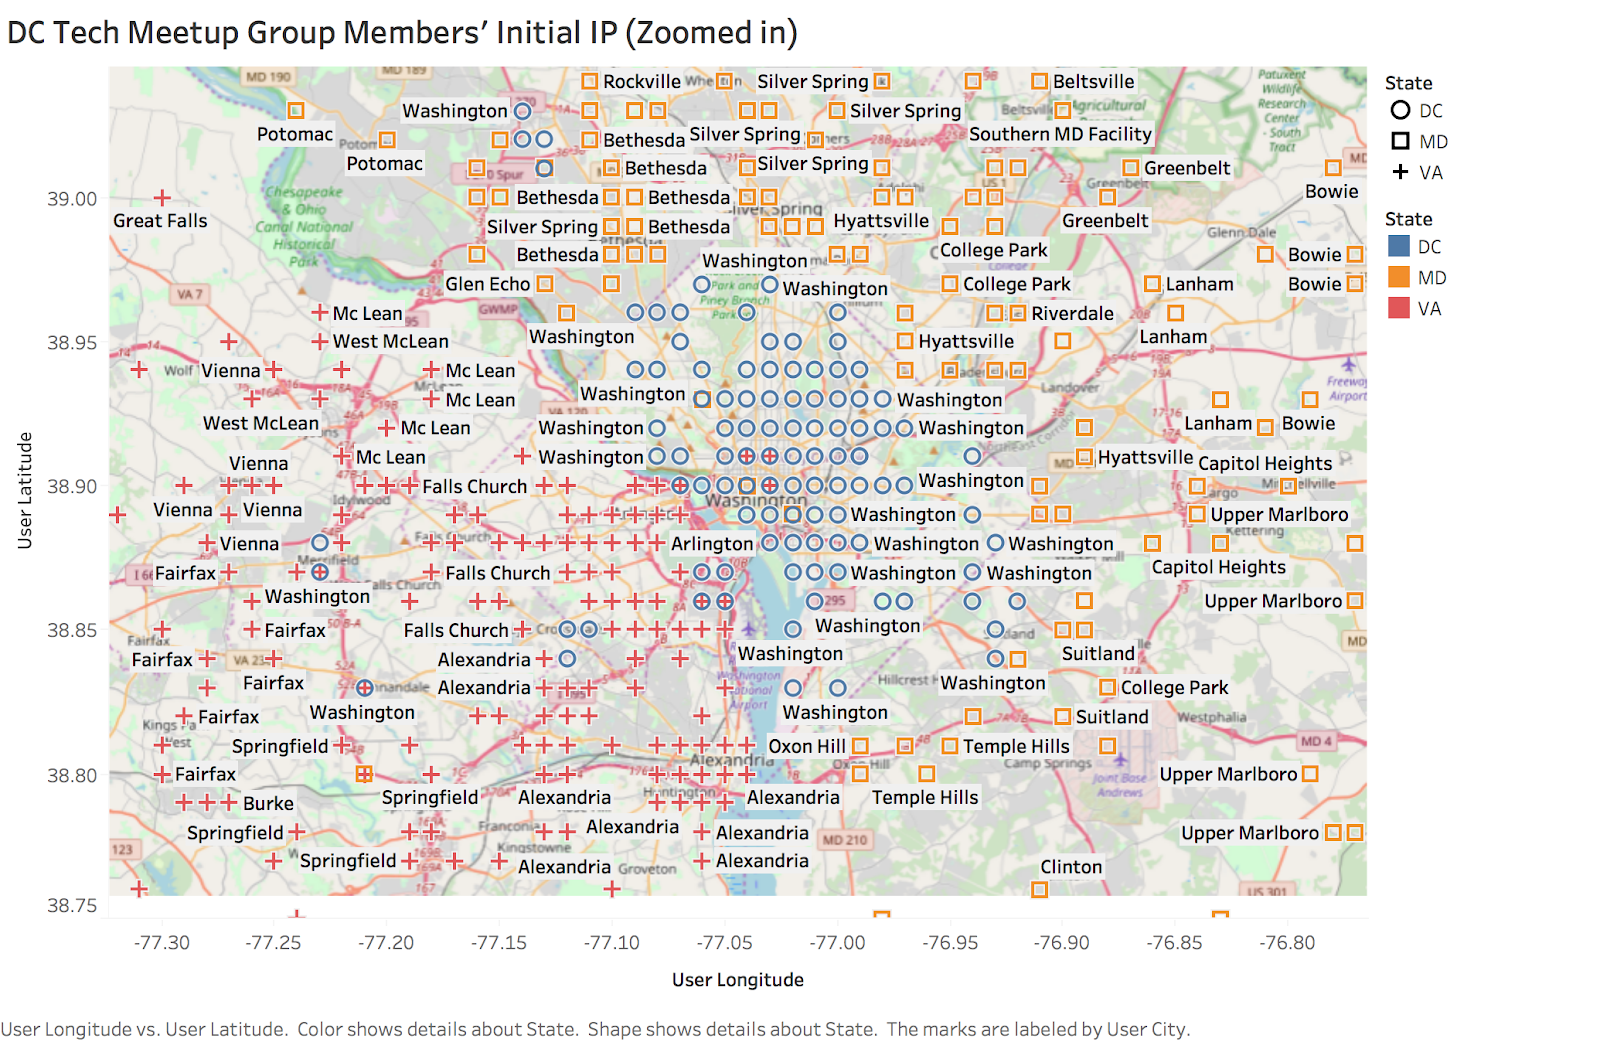
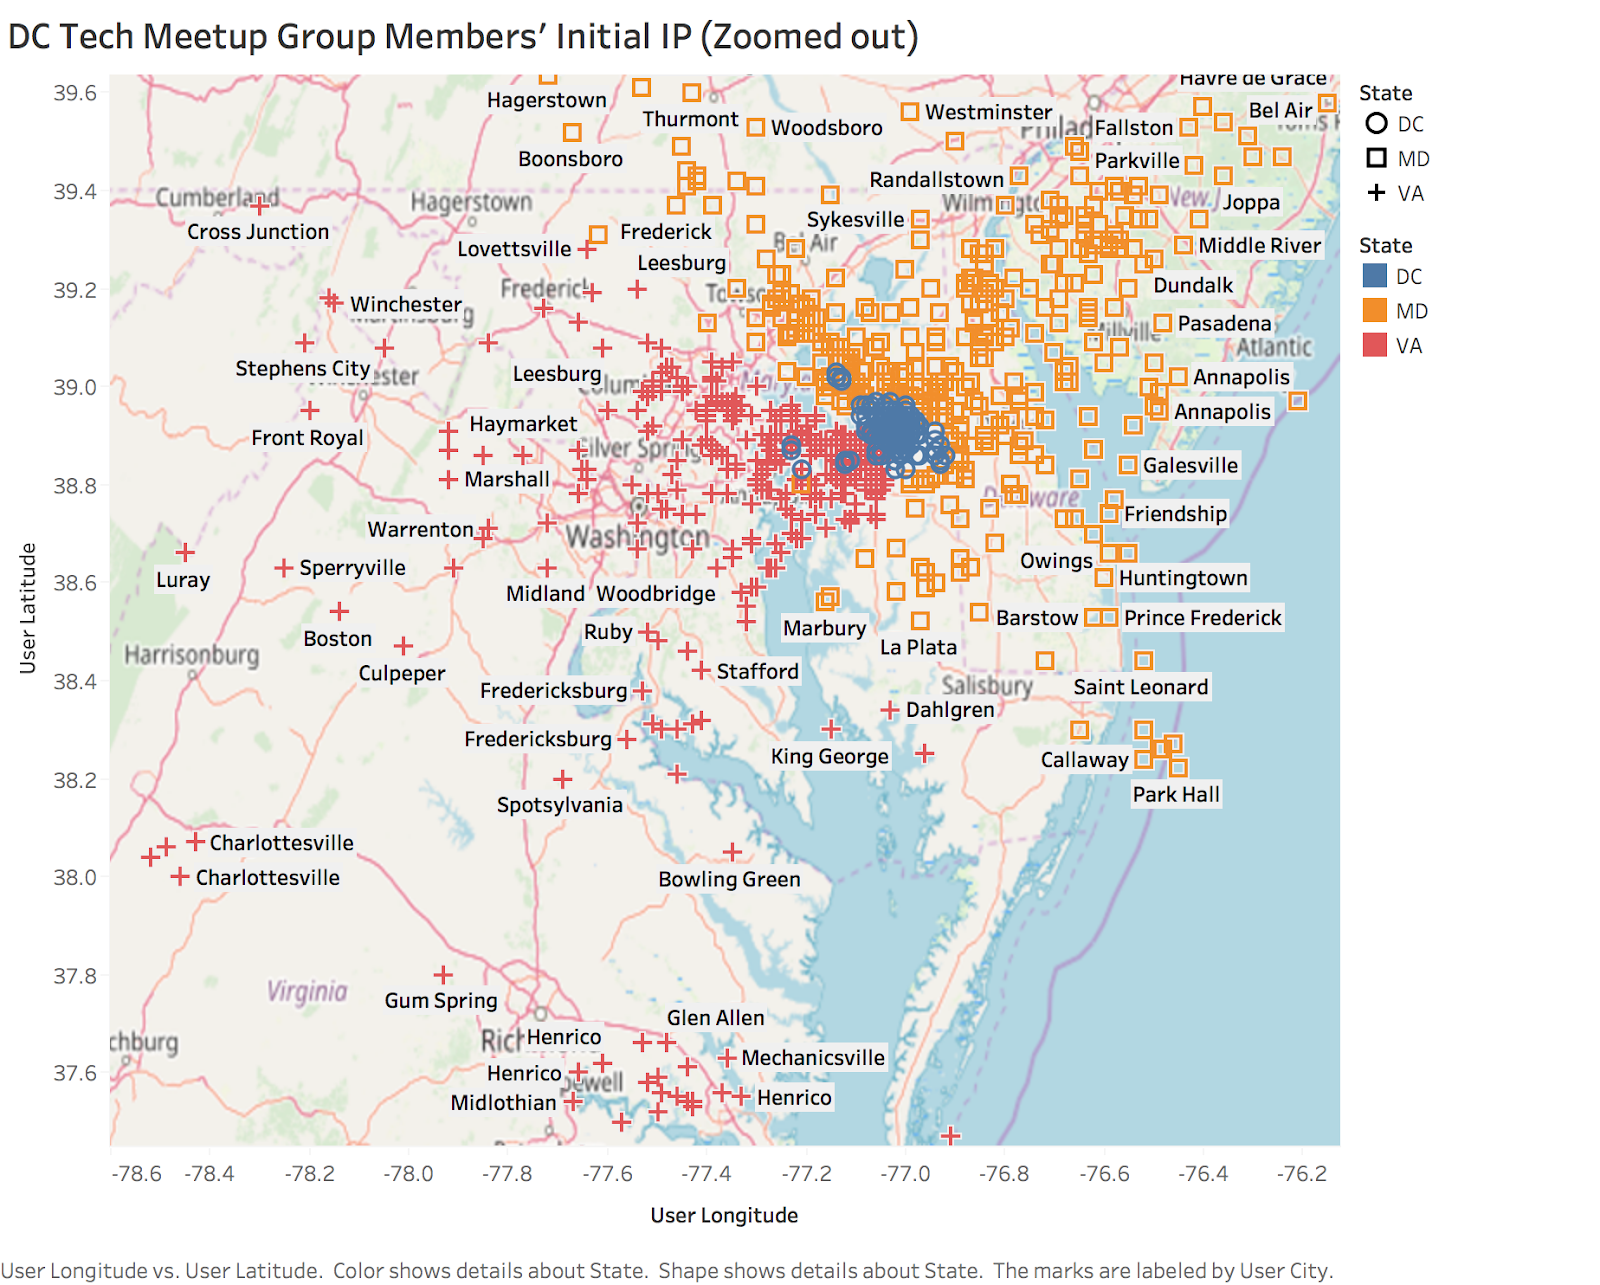
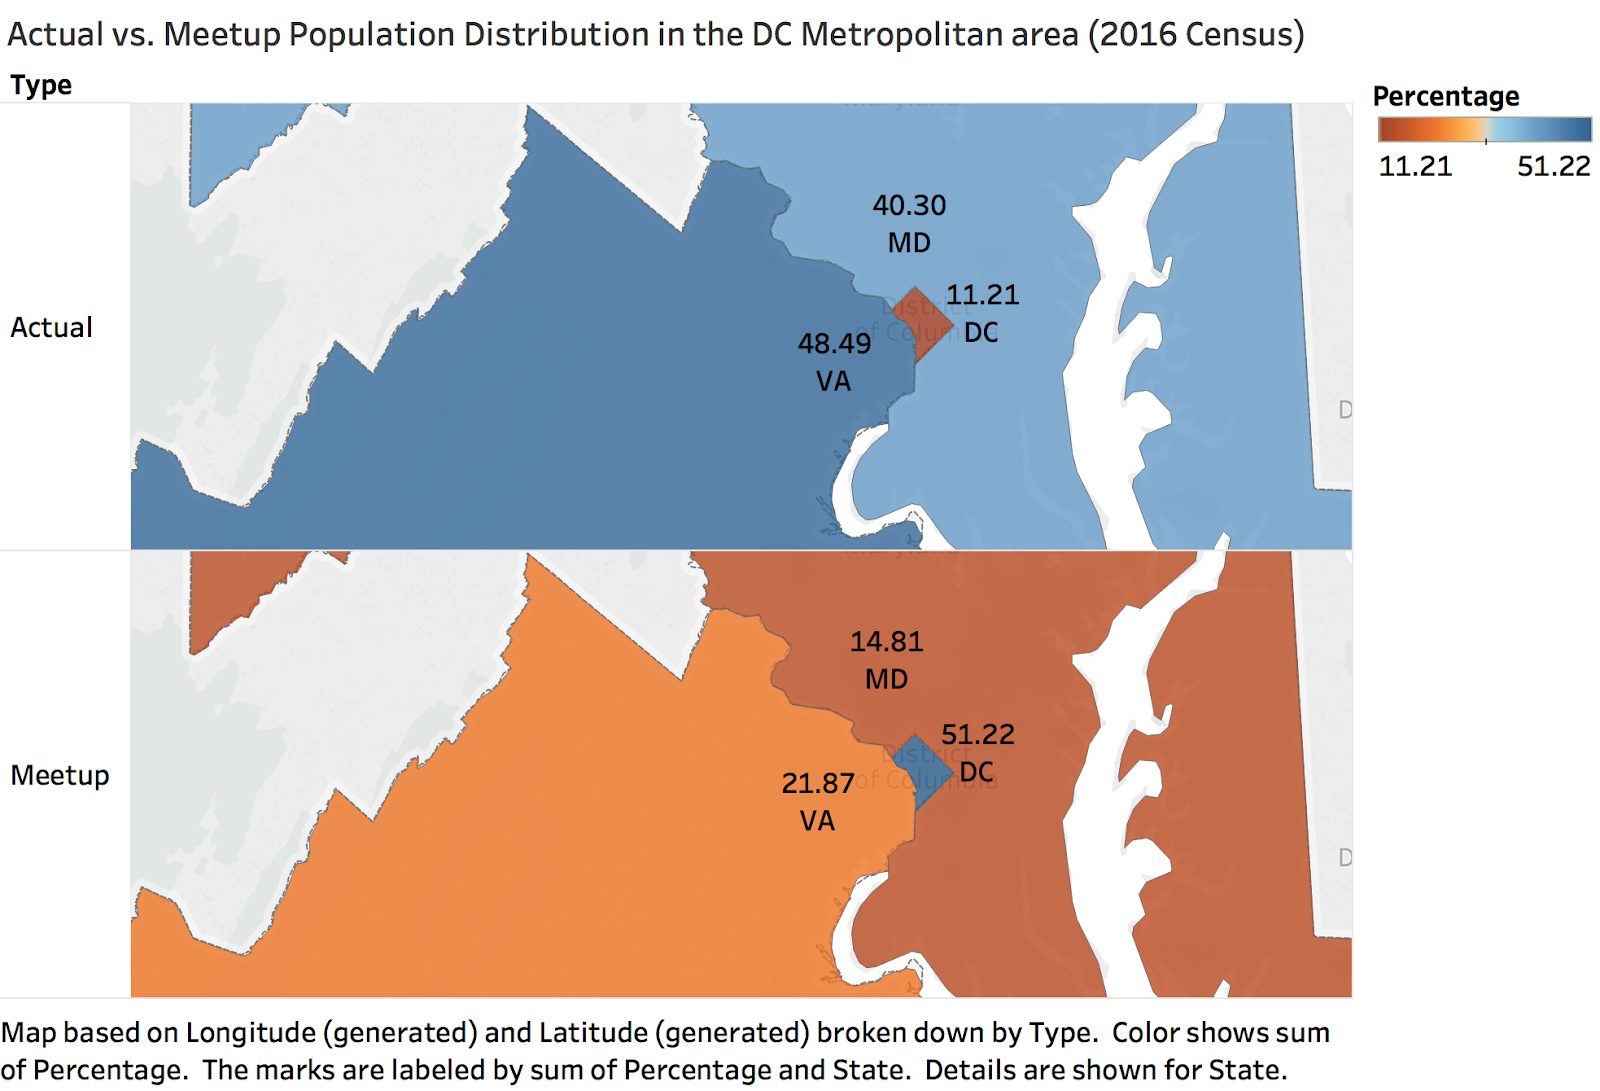

In addition, we used a chi-square test to rigorously assess the degree to which the Meetup data fits the recorded census data.

In [35]:
meetup = comparisonDf.iloc[3:6, 2]
meetup.index = [0, 1, 2]
total = sum(meetup)
estimated = pd.Series([total, total, total])*comparisonDf.iloc[0:3, 3]/100
chisq = sum( (meetup - estimated)**2/estimated )
print(chisq)


48740.06981347708635345116477


We found the difference in distributions to be highly significant (p < .0001, df = 2).

## Results

Overall, we found the distribution of DC-tech Meetup users to differ significantly from the underlying population distribution of the greater DC area. In particular, the majority of group members live in DC proper, while the vast majority of individuals living in the greater DC area live in Virginia or Maryland. From our results, we can tentatively conclude that inhabitants of DC weight the travel distance to a Meetup highly when deciding whether or not to join.

## Future Thoughts

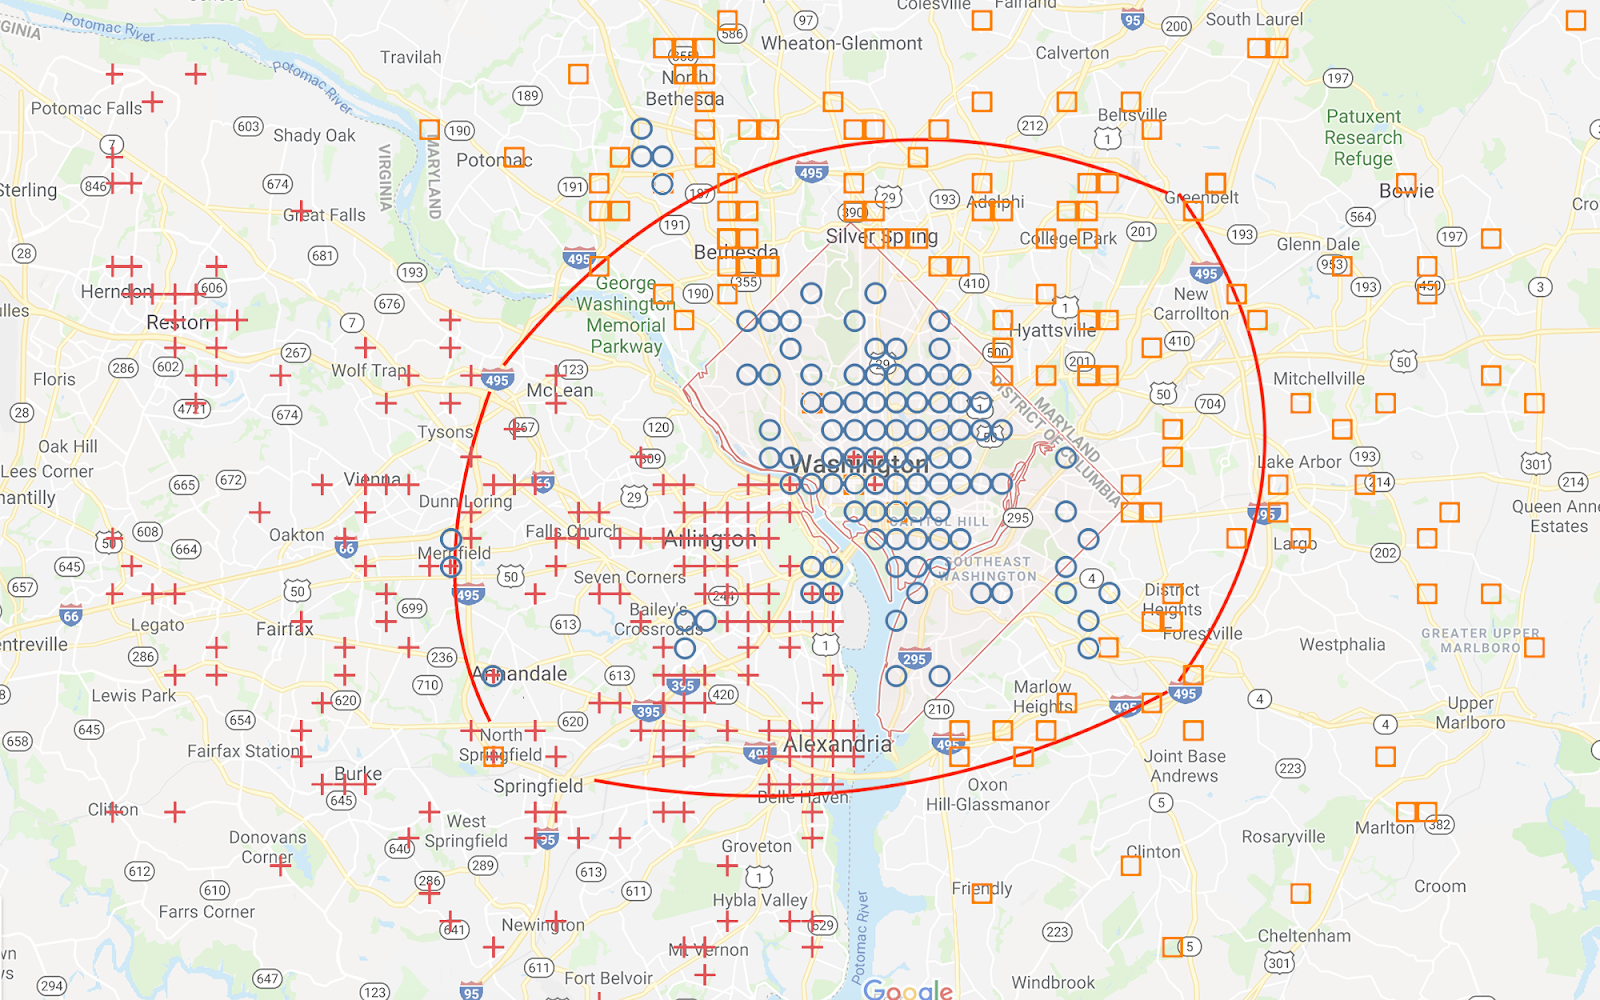

A potential confounding variable is that we only sampled one Meetup group in DC. Although the DC-Tech-Meetup group indicated that the majority of the group lives in DC, this might not be the case for all groups in DC.

Going forward, we would want to sample more Meetup groups in DC to see if results hold true. Furthermore, we would want to replicate the study to see if results might yield similar effects in other cities, as geography may be less important to individuals used to a longer commute or more heavily immersed in the tech industry (e.g. those living in California). In addition, sampling a wider variety of groups from Meetup may reveal differences in individual behavior based on group topic. Are people interested in food or drama less willing to travel for their hobbies? Do interests or proximity matter more?

Depending on how hard you squint at the graph above, one might be able to detect that there is a higher population density located inside the beltway (red 495 circle in the graph above). Therefore we would like to investigate, whether or not  major highways impact the likelihood of someone joining a Meetup.

Finally, a last vein of future research might investigate this phenomenon over time. Given continuing advances in technology, particularly telecommunications, will inhabitants of urban areas become increasingly reluctant to travel far when physically meeting others? Perhaps the analysis of Meetup data collected over a span of years could bring some insight.
